<a href="https://colab.research.google.com/github/shyamjith94/TimeSeriesDataAnalysis/blob/main/KerasRNNTimeSeries_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler

from keras.preprocessing.sequence import TimeseriesGenerator

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [3]:
data = pd.read_csv("/content/drive/MyDrive/TimeSeriesDataAnalysis/Data/Miles_Traveled.csv", index_col='DATE', parse_dates=True)

In [4]:
data.head()

,TRFVOLUSM227NFWA
DATE,
1970-01-01,80173.0
1970-02-01,77442.0
1970-03-01,90223.0
1970-04-01,89956.0
1970-05-01,97972.0


In [5]:
data.index.freq = 'MS'

In [7]:
data.index

DatetimeIndex(['1970-01-01', '1970-02-01', '1970-03-01', '1970-04-01',
               '1970-05-01', '1970-06-01', '1970-07-01', '1970-08-01',
               '1970-09-01', '1970-10-01',
               ...
               '2018-03-01', '2018-04-01', '2018-05-01', '2018-06-01',
               '2018-07-01', '2018-08-01', '2018-09-01', '2018-10-01',
               '2018-11-01', '2018-12-01'],
              dtype='datetime64[ns]', name='DATE', length=588, freq='MS')

In [8]:
data.columns = ['value']

In [9]:
data.head()

,value
DATE,
1970-01-01,80173.0
1970-02-01,77442.0
1970-03-01,90223.0
1970-04-01,89956.0
1970-05-01,97972.0


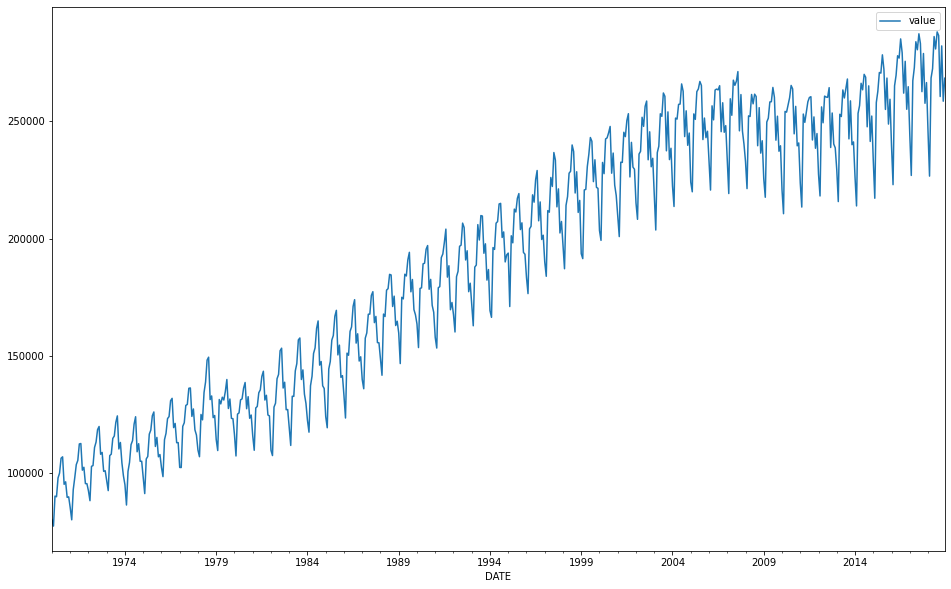

In [11]:
data.plot(figsize=(16,10))

Text(0, 0.5, 'resid')

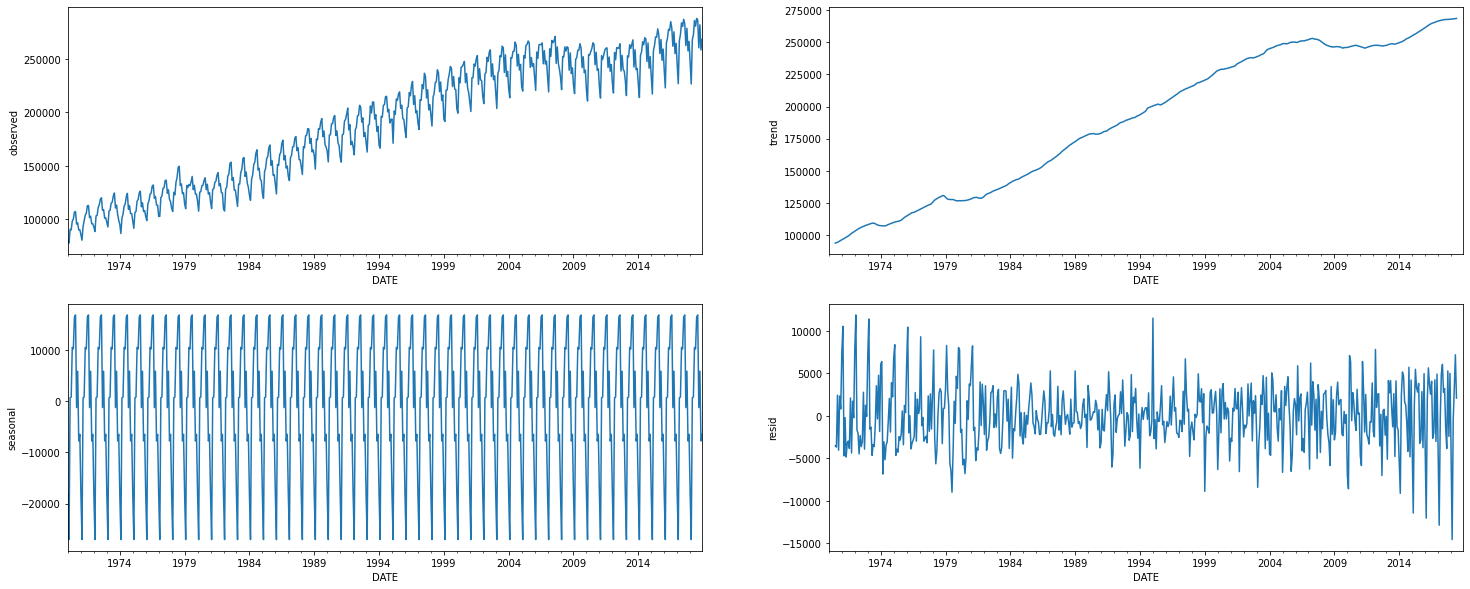

In [13]:
result = seasonal_decompose(data['value'])
fig, axe = plt.subplots(2,2,figsize=(25,10))

result.observed.plot(ax=axe[0,0])
axe[0,0].set_ylabel("observed")

result.trend.plot(ax=axe[0,1])
axe[0,1].set_ylabel("trend")

result.seasonal.plot(ax=axe[1,0])
axe[1,0].set_ylabel("seasonal")

result.resid.plot(ax=axe[1,1])
axe[1,1].set_ylabel("resid")

In [15]:
len(data)
train_data = data.iloc[:576]
test_data = data.iloc[576:]

In [17]:
scaler = MinMaxScaler()
scaler.fit(train_data)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [19]:
scaled_train = scaler.transform(train_data)
scaled_test = scaler.transform(test_data)

In [20]:
n_input = 24
n_future = 1
train_generated = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [23]:
model = Sequential()
model.add(LSTM(150, input_shape=(n_input, n_future), activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense (Dense)                (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.fit_generator(train_generated, epochs=100)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
552/552 [==============================] - 6s 12ms/step - loss: 0.0136
Epoch 2/100
552/552 [==============================] - 6s 11ms/step - loss: 0.0061
Epoch 3/100
552/552 [==============================] - 6s 11ms/step - loss: 0.0064
Epoch 4/100
552/552 [==============================] - 7s 12ms/step - loss: 0.0048
Epoch 5/100
552/552 [==============================] - 6s 12ms/step - loss: 0.0043
Epoch 6/100
552/552 [==============================] - 7s 12ms/step - loss: 0.0032
Epoch 7/100
552/552 [==============================] - 6s 11ms/step - loss: 0.0024
Epoch 8/100
552/552 [==============================] - 6s 11ms/step - loss: 0.0018
Epoch 9/100
552/552 [==============================] - 6s 12ms/step - loss: 0.0014
Epoch 10/100
552/552 [==============================] - 7s 12ms/step - loss: 0.0014
Epoch 11/100
552/552 [==============================] - 6s 11ms/step - loss: 0.0014
Epoch 12/

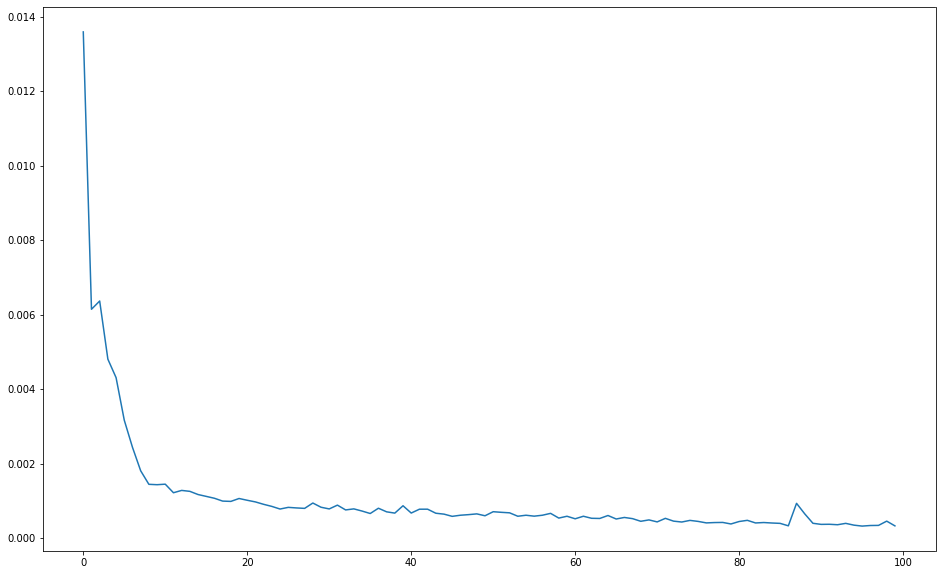

In [27]:
plt.figure(figsize=(16,10))
plt.plot(range(len(model.history.history['loss'])), model.history.history['loss'])

In [30]:
first_eval_batch = scaled_train[-12:]
first_eval_batch

array([[0.79630397],
       [0.71226435],
       [0.90477416],
       [0.93121043],
       [0.98386382],
       [0.96757519],
       [1.        ],
       [0.9801859 ],
       [0.8824684 ],
       [0.95995255],
       [0.85883345],
       [0.90086755]])

In [31]:
test_prediction = []
first_evaluation_batch = scaled_train[-n_input:]
current_batch =  first_evaluation_batch.reshape((1, n_input, n_future)) 

for i in range(len(test_data)):
    current_pred = model.predict(current_batch)[0]
    test_prediction.append(current_pred)
    # update current batch, drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)
print(scaled_test)
print("\n")
test_prediction

[[0.80158265]
 [0.71089704]
 [0.91013382]
 [0.92916661]
 [0.99438307]
 [0.969195  ]
 [1.00382085]
 [0.99649835]
 [0.8725685 ]
 [0.9753741 ]
 [0.86301637]
 [0.90981463]]




[array([0.8018491], dtype=float32),
 array([0.72923124], dtype=float32),
 array([0.9131347], dtype=float32),
 array([0.9005518], dtype=float32),
 array([0.9445201], dtype=float32),
 array([0.94117814], dtype=float32),
 array([0.95199835], dtype=float32),
 array([0.94150496], dtype=float32),
 array([0.8700026], dtype=float32),
 array([0.9011121], dtype=float32),
 array([0.8484142], dtype=float32),
 array([0.8457812], dtype=float32)]

In [32]:
true_prediction = scaler.inverse_transform(test_prediction)
print(true_prediction)
print("\n")
test_data['true_prediction'] = true_prediction
print(test_data)

[[245750.93356776]
 [230508.36616409]
 [269109.88542616]
 [266468.72252369]
 [275697.71683753]
 [274996.23339897]
 [277267.40629399]
 [275064.83162069]
 [260056.42148817]
 [266586.32662439]
 [255524.98535514]
 [254972.32114828]]


               value  true_prediction
DATE                                 
2018-01-01  245695.0    245750.933568
2018-02-01  226660.0    230508.366164
2018-03-01  268480.0    269109.885426
2018-04-01  272475.0    266468.722524
2018-05-01  286164.0    275697.716838
2018-06-01  280877.0    274996.233399
2018-07-01  288145.0    277267.406294
2018-08-01  286608.0    275064.831621
2018-09-01  260595.0    260056.421488
2018-10-01  282174.0    266586.326624
2018-11-01  258590.0    255524.985355
2018-12-01  268413.0    254972.321148


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


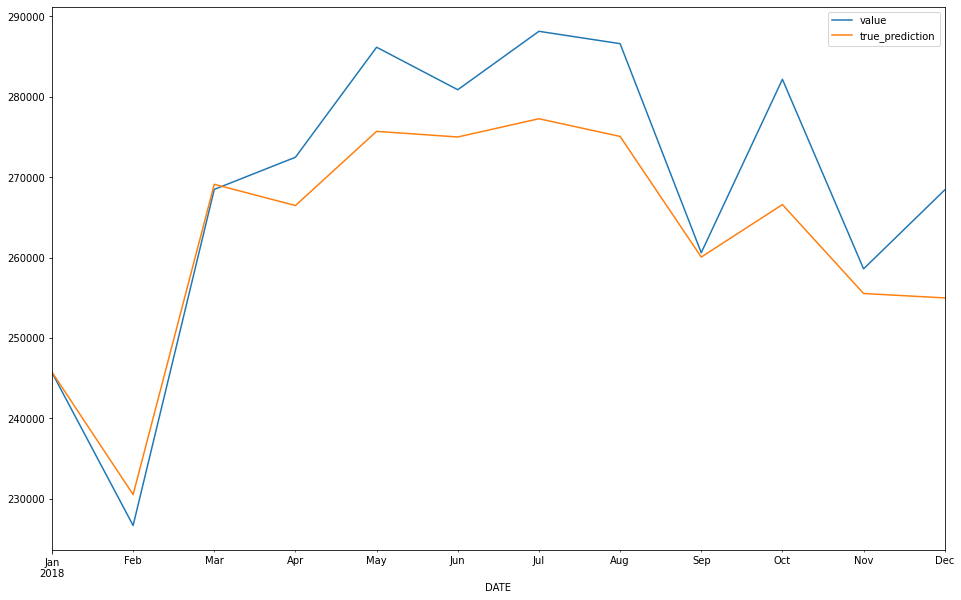

In [33]:
test_data.plot(figsize=(16,10), legend=True)